# Model Exploration

## Imports <a name="imports"></a>

In [1]:
#Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV

#Regression Metrics
from sklearn.metrics import mean_squared_error

#Classification Models
from sklearn.cluster import KMeans
from scipy.stats import norm
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

#XGBoost
import xgboost as xgb

#Classification Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from yellowbrick.classifier import ClassPredictionError
from yellowbrick.regressor import PredictionError
from yellowbrick.features import Rank1D
from yellowbrick.features import Rank2D
from yellowbrick.features import RadViz

import datetime

## Import Data <a name="importData"></a>

In [29]:
full_df = pd.read_csv("../../../Data_thesis/Full_Datasets/Full.csv")
full_df["Date"] = pd.to_datetime(full_df["Date"], format="%Y-%m-%d")

In [30]:
full_df.head()

,Date,Hour,Nieuwmarkt Arrivals,Nieuwezijds Kolk Arrivals,Dam Arrivals,Spui Arrivals,Nieuwmarkt Departures,Nieuwezijds Kolk Departures,Dam Departures,Spui Departures,...,SensorLatitude,CrowdednessCount,is_event,Year,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,2018-03-11,2400,77.0,38.0,187.0,40.0,198.0,63.0,411.0,87.0,...,6,0,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-2.449294e-16,1.000000
1,2018-03-11,2100,136.0,80.0,409.0,40.0,211.0,119.0,858.0,94.0,...,0,21,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-7.071068e-01,0.707107
2,2018-03-11,2100,136.0,80.0,409.0,40.0,211.0,119.0,858.0,94.0,...,9,88,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-7.071068e-01,0.707107
3,2018-03-11,2100,136.0,80.0,409.0,40.0,211.0,119.0,858.0,94.0,...,2,49,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-7.071068e-01,0.707107
4,2018-03-11,2200,116.0,64.0,288.0,21.0,210.0,103.0,732.0,98.0,...,8,2900,0.0,2018,1.0,6.123234e-17,0.188227,0.982126,-5.000000e-01,0.866025


## Sensor Dict
Dict with the labels of all the given sensors. This changes with each new DF construction

In [31]:
sensor_dict = {}
sensors = full_df.Sensor.unique()

for sensor in sensors:
    temp_df = full_df[full_df["Sensor"] == sensor].reset_index()
    
    sensor_dict[sensor] = {"Lat": temp_df["SensorLatitude"][0], "Lon": temp_df["SensorLongitude"][0]}

In [32]:
sensor_dict

{'GAWW-02': {'Lat': 6, 'Lon': 7},
 'GAWW-08': {'Lat': 0, 'Lon': 0},
 'GAWW-09': {'Lat': 9, 'Lon': 5},
 'GAWW-10': {'Lat': 2, 'Lon': 6},
 'GAWW-01': {'Lat': 8, 'Lon': 8},
 'GAWW-03': {'Lat': 4, 'Lon': 1},
 'GAWW-04': {'Lat': 5, 'Lon': 3},
 'GAWW-05': {'Lat': 1, 'Lon': 2},
 'GAWW-06': {'Lat': 3, 'Lon': 4},
 'GAWW-07': {'Lat': 7, 'Lon': 9}}

### Visualization

In [4]:
x = full_df.drop(["CrowdednessCount", "Date", "Hour", "Sensor"], axis=1)
y = full_df["CrowdednessCount"]

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\yellowbrick\features\rankd.py:262: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  X = X.as_matrix()
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


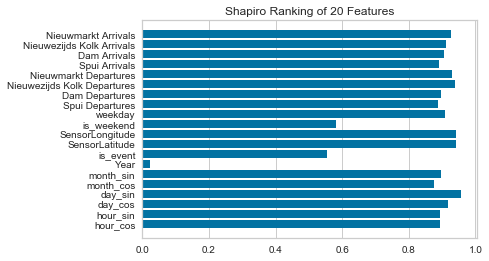

In [5]:
#Rank features - 1D
visualizer = Rank1D(algorithm='shapiro')

visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

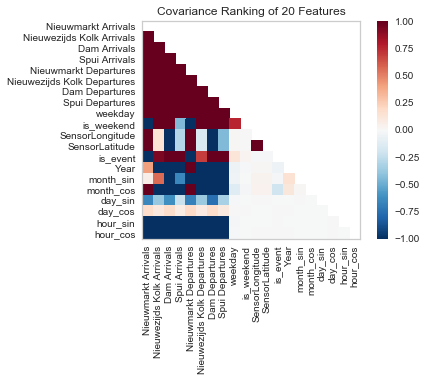

In [6]:
visualizer = Rank2D(algorithm='covariance')
visualizer.fit(x, y)                # Fit the data to the visualizer
visualizer.transform(x)             # Transform the data
visualizer.poof() 

### Split Data into Training/Test and Time Series data

In [99]:
split_date = pd.Timestamp(2018, 12, 31)

TrainTest_df = full_df[full_df["Date"] <= split_date].reset_index().drop(columns=["index", "Hour", "Sensor", "Year"])
TimeSeries_df = full_df[full_df["Date"] > split_date].reset_index().drop(columns=["index", "Hour", "Sensor", "Year"])

### Criteria for train and test Model <a name="testModel"></a>
Divide set based on dates

In [8]:
all_dates = TrainTest_df["Date"].values
np.random.shuffle(all_dates)

split_dates = int(all_dates.size * 0.9)
train_set_dates = all_dates[:split_dates]
test_set_dates = all_dates[split_dates:]

Test only on selected sensor

In [34]:
test_sensor = "GAWW-02"

test_lat = sensor_dict[test_sensor]["Lat"]

Select start and end period evaluation

In [45]:
eval_start_date = pd.Timestamp(2019, 1, 1)
eval_end_date = pd.Timestamp(2019, 1, 31)

## Regression Models <a name="regModels"></a>

### Train, Test, Evaluation Split

In [10]:
train_df_reg = TrainTest_df[TrainTest_df["Date"].isin(train_set_dates)].reset_index().drop(columns=["Date","index"])

test_df_reg = TrainTest_df[TrainTest_df["Date"].isin(test_set_dates)].reset_index().drop(columns=["index"])

In [100]:
#Train
x_train_reg = train_df_reg.drop(["CrowdednessCount"], axis=1)
y_train_reg = train_df_reg["CrowdednessCount"]

#Test
x_test_reg = test_df_reg.drop(["CrowdednessCount", "Date"], axis=1)
y_test_reg = test_df_reg["CrowdednessCount"]

test_reg_series = test_df_reg[(test_df_reg["SensorLatitude"] == test_lat) & 
                              (test_df_reg["Date"] == test_set_dates[0])].reset_index()
x_test_reg_series = test_reg_series.drop(["CrowdednessCount", "Date", "index"], axis=1)
y_test_reg_series = test_reg_series["CrowdednessCount"]

#Timeseries
x_eval_reg = TimeSeries_df.drop(["CrowdednessCount", "Date"], axis=1)
y_eval_reg = TimeSeries_df["CrowdednessCount"]

#Subset timeseries
sub_series = TimeSeries_df[(TimeSeries_df["SensorLatitude"] == test_lat) & 
                           (TimeSeries_df["Date"] >= eval_start_date) & 
                           (TimeSeries_df["Date"] <= eval_end_date)].reset_index()

#Time series
x_series_reg = sub_series.drop(["Date","CrowdednessCount", "index"], axis=1)
y_series_reg = sub_series["CrowdednessCount"]


feature_labels_reg = train_df_reg.columns.values

### Linear Regression <a name="regBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression)

#### Training

In [48]:
#Give parameters model
reg_base = LinearRegression()

In [49]:
#Fit the model
reg_base.fit(x_train_reg, y_train_reg)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

#### Test

In [50]:
reg_base_score = reg_base.score(x_test_reg, y_test_reg)

y_pred_reg_base = reg_base.predict(x_test_reg)
base_reg_mse = mean_squared_error(y_pred_reg_base, y_test_reg)

print("R^2 Score: ", reg_base_score)
print("MSE: ", base_reg_mse)
print("RMSE: ", np.sqrt(base_reg_mse))

R^2 Score:  0.3162481282574323
MSE:  742051.0028203806
RMSE:  861.4238229932932


In [51]:
for i in range(10):
    print("Predicted: ", y_pred_reg_base[i], "Real: ", y_test_reg[i])

Predicted:  1418.802223427357 Real:  0
Predicted:  1118.5452347829073 Real:  21
Predicted:  1375.8789347408347 Real:  88
Predicted:  1665.1442642229592 Real:  49
Predicted:  1642.0413070530587 Real:  2900
Predicted:  1595.979080458986 Real:  0
Predicted:  1049.3800510189337 Real:  83
Predicted:  1222.572205169764 Real:  822
Predicted:  1230.5551125508132 Real:  2661
Predicted:  1376.7246997140821 Real:  3291


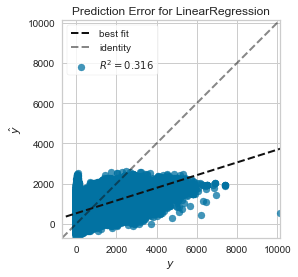

In [52]:
visualizer = PredictionError(reg_base)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [53]:
#Time series
time_pred_reg_lr = reg_base.predict(x_test_reg_series)

time_pred_series_reg_lr = pd.Series(time_pred_reg_lr)
time_real_series_reg_lr = pd.Series(y_test_reg_series)

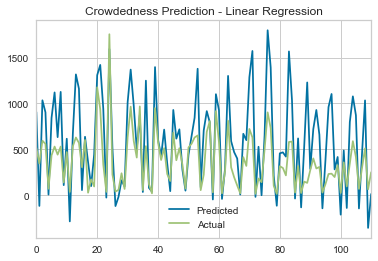

In [54]:
time_pred_series_reg_lr.plot(legend=True, title='Crowdedness Prediction - Linear Regression', label="Predicted")
time_real_series_reg_lr.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [55]:
base_score = reg_base.score(x_eval_reg, y_eval_reg)

y_pred_base = reg_base.predict(x_eval_reg)
base_mse = mean_squared_error(y_pred_base, y_eval_reg)

print("R^2 Score: ", base_score)
print("MSE: ", base_mse)
print("RMSE: ", np.sqrt(base_mse))

R^2 Score:  0.26370521205854014
MSE:  454874.4098276554
RMSE:  674.4437781073049


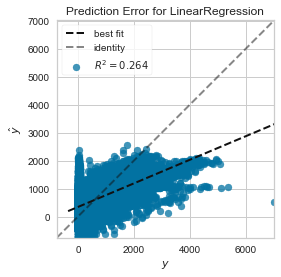

In [56]:
visualizer = PredictionError(reg_base)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [57]:
#Time series
time_pred_lr = reg_base.predict(x_series_reg)

time_pred_series_lr = pd.Series(time_pred_lr)
time_real_series_lr = pd.Series(y_series_reg)

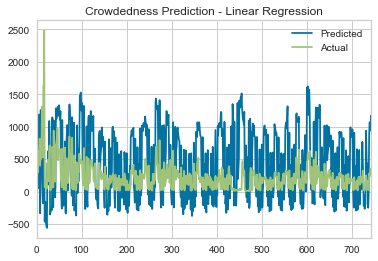

In [58]:
time_pred_series_lr.plot(legend=True, title='Crowdedness Prediction - Linear Regression', label="Predicted")
time_real_series_lr.plot(legend=True, label="Actual")
plt.show()

### Random Forrest Regressor <a name="regRFGModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

Parameters
- *N-Estimators*: Number of trees in the model
- *criterion*: loss function
- *n_jobs*: The number of jobs to run in parallel for both fit and predict
- *random_state*: random_state is the seed used by the random number generator
- *bootstrap*: Whether bootstrap samples are used when building trees

#### Training

In [59]:
#Set parameters model
reg_rfg = RandomForestRegressor(n_estimators=500, criterion="mse", n_jobs=100, random_state=42, bootstrap=True, 
                               oob_score=True)

In [60]:
#fit the model
reg_rfg.fit(x_train_reg, y_train_reg)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=100,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

#### Test

In [61]:
#Score the model
reg_rfg_score = reg_rfg.score(x_test_reg, y_test_reg)

#Test
y_pred_reg_rfg = reg_rfg.predict(x_test_reg)
reg_rfg_mse = mean_squared_error(y_pred_reg_rfg, y_test_reg)

print("R^2 Score: ", reg_rfg_score)
print("MSE Test: ", reg_rfg_mse)
print("RMSE Test: ", np.sqrt(reg_rfg_mse))

R^2 Score:  0.9914436087268723
MSE Test:  9285.939808203531
RMSE Test:  96.36358133757551


In [62]:
for i in range(10):
    print("Predicted: ", y_pred_reg_rfg[i], "Real: ", y_test_reg[i])

Predicted:  645.672 Real:  0
Predicted:  24.724 Real:  21
Predicted:  83.354 Real:  88
Predicted:  45.866 Real:  49
Predicted:  2680.452 Real:  2900
Predicted:  408.474 Real:  0
Predicted:  78.116 Real:  83
Predicted:  741.272 Real:  822
Predicted:  2704.02 Real:  2661
Predicted:  3086.318 Real:  3291


In [63]:
#Feature importance
importance = reg_rfg.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels_reg[index], (importance[index] *100.0)))

Dam Departures-3.44%
day_cos-10.91%
SensorLatitude-12.61%
day_sin-18.65%
SensorLongitude-36.60%


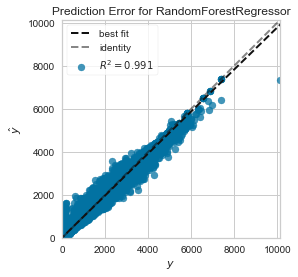

In [64]:
visualizer = PredictionError(reg_rfg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [65]:
#Time series
time_pred_reg_rfg = reg_rfg.predict(x_test_reg_series)

time_pred_series_reg_rfg = pd.Series(time_pred_reg_rfg)
time_real_series_reg_rfg = pd.Series(y_test_reg_series)

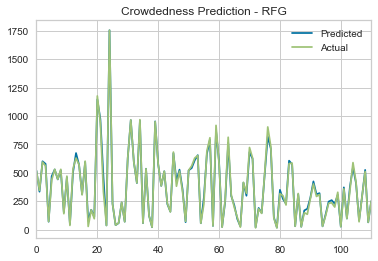

In [66]:
time_pred_series_reg_rfg.plot(legend=True, title='Crowdedness Prediction - RFG', label="Predicted")
time_real_series_reg_rfg.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [67]:
#Score the model
rfg_score = reg_rfg.score(x_eval_reg, y_eval_reg)

#Test
y_pred_rfg = reg_rfg.predict(x_eval_reg)
rfg_mse = mean_squared_error(y_pred_rfg, y_eval_reg)

print("R^2 Score: ", rfg_score)
print("MSE Test: ", rfg_mse)
print("RMSE Test: ", np.sqrt(rfg_mse))

R^2 Score:  0.5164526122287796
MSE Test:  298729.98728007573
RMSE Test:  546.5619702102184


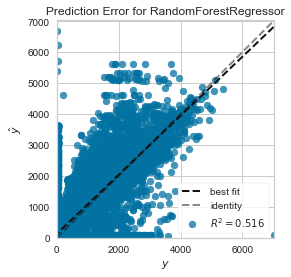

In [68]:
visualizer = PredictionError(reg_rfg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [69]:
#Time series
time_pred_rfg = reg_rfg.predict(x_series_reg)

time_pred_series_rfg = pd.Series(time_pred_rfg)
time_real_series_rfg = pd.Series(y_series_reg)

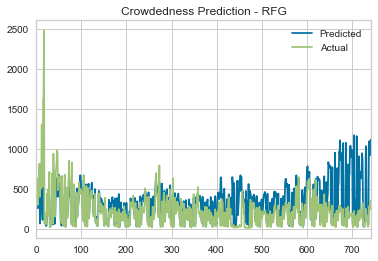

In [70]:
time_pred_series_rfg.plot(legend=True, title='Crowdedness Prediction - RFG', label="Predicted")
time_real_series_rfg.plot(legend=True, label="Actual")
plt.show()

### XGBoost Regressor
Through [SciKit-Learn API](https://xgboost.readthedocs.io/en/latest/python/python_api.html) 

#### Training

In [71]:
xgb_reg = xgb.XGBRegressor(max_depth=6, learning_rate=0.1, n_estimators=300, verbosity=1,
                          booster="gbtree", n_jobs=20, random_state=42)

In [72]:
xgb_reg.fit(x_train_reg, y_train_reg)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=300, n_jobs=20,
       nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1, verbosity=1)

#### Test

In [73]:
reg_xgb_score = xgb_reg.score(x_test_reg, y_test_reg)

#Training
y_pred_reg_xgb = xgb_reg.predict(x_test_reg)
reg_xgb_mse = mean_squared_error(y_pred_reg_xgb, y_test_reg)

print("R^2 Score: ", reg_xgb_score)
print("MSE Test: ", reg_xgb_mse)
print("RMSE Test: ", np.sqrt(reg_xgb_mse))

R^2 Score:  0.9514142948674571
MSE Test:  52728.29619384613
RMSE Test:  229.6264274726368


In [74]:
for i in range(10):
    print("Predicted: ", y_pred_reg_xgb[i], "Real: ", y_test_reg[i])

Predicted:  1380.6581 Real:  0
Predicted:  25.288248 Real:  21
Predicted:  98.93854 Real:  88
Predicted:  81.63896 Real:  49
Predicted:  2407.0083 Real:  2900
Predicted:  1213.0134 Real:  0
Predicted:  154.83342 Real:  83
Predicted:  509.57397 Real:  822
Predicted:  2279.7397 Real:  2661
Predicted:  2761.2656 Real:  3291


In [75]:
#Feature importance
importance = xgb_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()
feature_indexes_by_importance = feature_indexes_by_importance[-5:]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels_reg[index], (importance[index] *100.0)))

SensorLatitude-5.67%
weekday-5.93%
day_cos-14.25%
SensorLongitude-14.83%
day_sin-38.52%


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


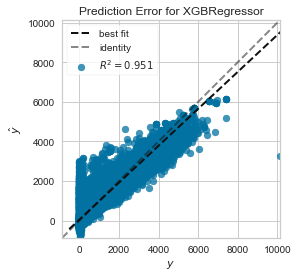

In [76]:
visualizer = PredictionError(xgb_reg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [77]:
#Time series
time_pred_reg_xgb = xgb_reg.predict(x_test_reg_series)

time_pred_series_reg_xgb = pd.Series(time_pred_reg_xgb)
time_real_series_reg_xgb = pd.Series(y_test_reg_series)

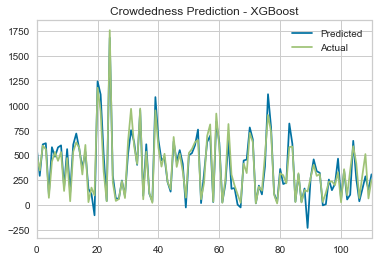

In [78]:
time_pred_series_reg_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_reg_xgb.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [79]:
xgb_score = xgb_reg.score(x_eval_reg, y_eval_reg)

#Training
y_pred_xgb = xgb_reg.predict(x_eval_reg)
xgb_mse = mean_squared_error(y_pred_xgb, y_eval_reg)

print("R^2 Score: ", xgb_score)
print("MSE Test: ", xgb_mse)
print("RMSE Test: ", np.sqrt(xgb_mse))

R^2 Score:  0.5292480513537833
MSE Test:  290825.11287950544
RMSE Test:  539.2820346344809


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
D:\Programs\Anaconda\envs\Analytics\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


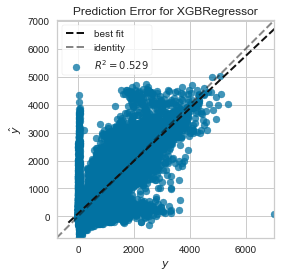

In [80]:
visualizer = PredictionError(xgb_reg)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [81]:
#Time series
time_pred_xgb = xgb_reg.predict(x_series_reg)

time_pred_series_xgb = pd.Series(time_pred_xgb)
time_real_series_xgb = pd.Series(y_series_reg)

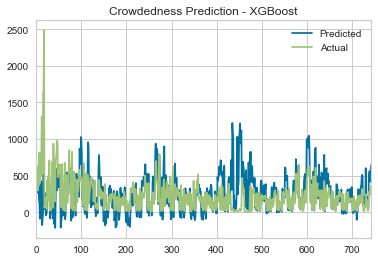

In [82]:
time_pred_series_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_xgb.plot(legend=True, label="Actual")
plt.show()

### Lasso <a name="regABRModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV)

#### Training

In [83]:
lasso = LassoCV(n_jobs=50, random_state=42, n_alphas=5, normalize=True, precompute="auto", selection="random")

In [84]:
lasso.fit(x_train_reg, y_train_reg)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=5, n_jobs=50, normalize=True, positive=False,
    precompute='auto', random_state=42, selection='random', tol=0.0001,
    verbose=False)

#### Test

In [85]:
reg_lasso_score=lasso.score(x_test_reg, y_test_reg)

y_pred_reg_lasso = lasso.predict(x_test_reg)
reg_lasso_mse = mean_squared_error(y_pred_reg_lasso, y_test_reg)

print("R^2 Sore: ", reg_lasso_score)
print("MSE: ", reg_lasso_mse)
print("RMSE: ", np.sqrt(reg_lasso_mse))

R^2 Sore:  0.3152895112879943
MSE:  743091.3549026048
RMSE:  862.027467603327


In [86]:
for i in range(10):
    print("Predicted: ", y_pred_reg_lasso[i], "Real: ", y_test_reg[i])

Predicted:  1383.936208799029 Real:  0
Predicted:  1098.651411406193 Real:  21
Predicted:  1366.6219221174438 Real:  88
Predicted:  1633.6993639159389 Real:  49
Predicted:  1620.2940374732843 Real:  2900
Predicted:  1571.5518294141307 Real:  0
Predicted:  1036.503876904385 Real:  83
Predicted:  1206.7667042691394 Real:  822
Predicted:  1206.5434370409505 Real:  2661
Predicted:  1352.5467939902226 Real:  3291


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


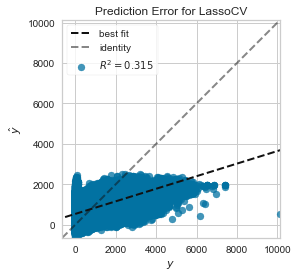

In [87]:
visualizer = PredictionError(lasso)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_test_reg, y_test_reg)  # Evaluate the model on the test data
g = visualizer.poof() 

In [88]:
#Time series
time_pred_reg_lasso = lasso.predict(x_test_reg_series)

time_pred_series_reg_lasso = pd.Series(time_pred_reg_lasso)
time_real_series_reg_lasso = pd.Series(y_test_reg_series)

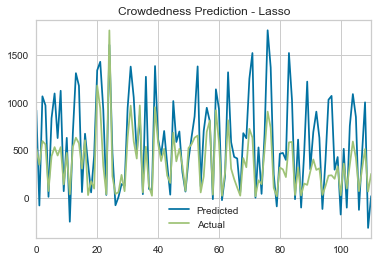

In [89]:
time_pred_series_reg_lasso.plot(legend=True, title='Crowdedness Prediction - Lasso', label="Predicted")
time_real_series_reg_lasso.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [90]:
lasso_score=lasso.score(x_eval_reg, y_eval_reg)

y_pred_lasso = lasso.predict(x_eval_reg)
lasso_mse = mean_squared_error(y_pred_lasso, y_eval_reg)

print("R^2 Sore: ", lasso_score)
print("MSE: ", lasso_mse)
print("RMSE: ", np.sqrt(lasso_mse))

R^2 Sore:  0.2672133895008971
MSE:  452707.0983516034
RMSE:  672.8351197370745


D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


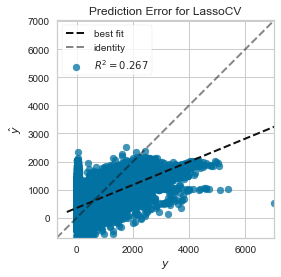

In [91]:
visualizer = PredictionError(lasso)
visualizer.fit(x_train_reg, y_train_reg)  # Fit the training data to the visualizer
visualizer.score(x_eval_reg, y_eval_reg)  # Evaluate the model on the test data
g = visualizer.poof()

In [92]:
#Time series
time_pred_lasso = lasso.predict(x_series_reg)

time_pred_series_lasso = pd.Series(time_pred_lasso)
time_real_series_lasso = pd.Series(y_series_reg)

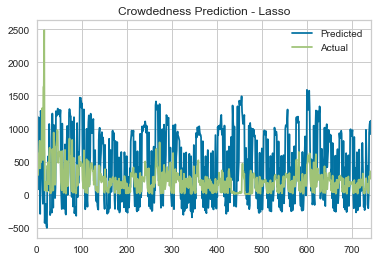

In [93]:
time_pred_series_lasso.plot(legend=True, title='Crowdedness Prediction - Lasso', label="Predicted")
time_real_series_lasso.plot(legend=True, label="Actual")
plt.show()

## Classification Models <a name="classification"></a>

### Change numerical labels to categorical labels <a name="classCatVar"></a>

In [103]:
low_split = TrainTest_df["CrowdednessCount"].quantile(.25)
mid_split = TrainTest_df["CrowdednessCount"].quantile(.5)
high_split = TrainTest_df["CrowdednessCount"].quantile(.75)

In [104]:
clas_dict = TrainTest_df.to_dict("index")

for k, v in clas_dict.items():
    
    if v["CrowdednessCount"] < low_split:
        v["CrowdednessCount"] = 1
    elif v["CrowdednessCount"] >= low_split and v["CrowdednessCount"] < mid_split:
        v["CrowdednessCount"] = 2
    elif v["CrowdednessCount"] >= mid_split and v["CrowdednessCount"] < high_split:
        v["CrowdednessCount"] = 3
    elif v["CrowdednessCount"] >= high_split:
        v["CrowdednessCount"] = 4
    else:
        print (k, " has class error as it fits in none")
    
clas_model_df = pd.DataFrame.from_dict(clas_dict, orient="index")

In [105]:
series_dict = TimeSeries_df.to_dict("index")

for k, v in series_dict.items():
    
    if v["CrowdednessCount"] < low_split:
        v["CrowdednessCount"] = 1
    elif v["CrowdednessCount"] >= low_split and v["CrowdednessCount"] < mid_split:
        v["CrowdednessCount"] = 2
    elif v["CrowdednessCount"] >= mid_split and v["CrowdednessCount"] < high_split:
        v["CrowdednessCount"] = 3
    elif v["CrowdednessCount"] >= high_split:
        v["CrowdednessCount"] = 4
    else:
        print (k, " has class error as it fits in none")
    
TimeSeries_df_clas = pd.DataFrame.from_dict(series_dict, orient="index")    

In [106]:
TimeSeries_df_clas.head()

,Date,Nieuwmarkt Arrivals,Nieuwezijds Kolk Arrivals,Dam Arrivals,Spui Arrivals,Nieuwmarkt Departures,Nieuwezijds Kolk Departures,Dam Departures,Spui Departures,weekday,...,SensorLongitude,SensorLatitude,CrowdednessCount,is_event,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
0,2019-01-01,10.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,1.0,...,8,8,4,0.0,0.5,0.866025,0.017213,0.999852,-2.449294e-16,1.000000e+00
1,2019-01-01,0.0,0.0,0.0,0.0,36.0,15.0,16.0,0.0,1.0,...,5,9,1,0.0,0.5,0.866025,0.017213,0.999852,1.000000e+00,6.123234e-17
2,2019-01-01,412.0,268.0,1130.0,113.0,370.0,192.0,1317.0,141.0,1.0,...,1,4,4,0.0,0.5,0.866025,0.017213,0.999852,-8.660254e-01,-5.000000e-01
3,2019-01-01,412.0,268.0,1130.0,113.0,370.0,192.0,1317.0,141.0,1.0,...,3,5,3,0.0,0.5,0.866025,0.017213,0.999852,-8.660254e-01,-5.000000e-01
4,2019-01-01,412.0,268.0,1130.0,113.0,370.0,192.0,1317.0,141.0,1.0,...,2,1,4,0.0,0.5,0.866025,0.017213,0.999852,-8.660254e-01,-5.000000e-01


In [107]:
train_df_clas = clas_model_df[clas_model_df["Date"].isin(train_set_dates)].reset_index().drop(columns=["Date","index"])

test_df_clas = clas_model_df[clas_model_df["Date"].isin(test_set_dates)].reset_index().drop(columns=["index"])

In [111]:
#Train
x_train_clas = train_df_clas.drop(["CrowdednessCount"], axis=1)
y_train_clas = train_df_clas["CrowdednessCount"]

#Test
x_test_clas = test_df_clas.drop(["CrowdednessCount", "Date"], axis=1)
y_test_clas = test_df_clas["CrowdednessCount"]

test_clas_series = test_df_clas[(test_df_clas["SensorLatitude"] == test_lat) & 
                              (test_df_clas["Date"] == test_set_dates[0])].reset_index()
x_test_clas_series = test_clas_series.drop(["CrowdednessCount", "Date", "index"], axis=1)
y_test_clas_series = test_clas_series["CrowdednessCount"]

#Time series
x_eval_clas = TimeSeries_df_clas.drop(["CrowdednessCount", "Date"], axis=1)
y_eval_clas = TimeSeries_df_clas["CrowdednessCount"]

sub_series_clas = TimeSeries_df_clas[(TimeSeries_df_clas["SensorLatitude"] == test_lat) & 
                           (TimeSeries_df_clas["Date"] >= eval_start_date) & 
                           (TimeSeries_df_clas["Date"] <= eval_end_date)].reset_index()

x_series_clas = sub_series_clas.drop(["CrowdednessCount", "Date","index"], axis=1)
y_series_clas = sub_series_clas["CrowdednessCount"]

### Baseline <a name="classBaseModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn.dummy.DummyClassifier)

Parameters
- *strategy*: "stratified” - generates predictions by respecting the training set’s class distribution.

#### Training

In [127]:
clas_bas = DummyClassifier(strategy="stratified", random_state=42)

In [128]:
clas_bas.fit(x_train_clas, y_train_clas)

DummyClassifier(constant=None, random_state=42, strategy='stratified')

#### Test

In [129]:
y_pred_clas_bas = clas_bas.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_bas))
print(classification_report(y_test_clas, y_pred_clas_bas))

Accuracy Score:  0.2513301545741704
              precision    recall  f1-score   support

           1       0.25      0.25      0.25     20795
           2       0.25      0.25      0.25     20795
           3       0.25      0.25      0.25     20845
           4       0.25      0.25      0.25     20826

   micro avg       0.25      0.25      0.25     83261
   macro avg       0.25      0.25      0.25     83261
weighted avg       0.25      0.25      0.25     83261



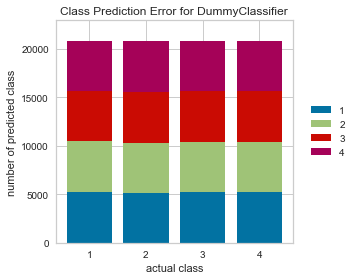

In [130]:
visualizer = ClassPredictionError(
    clas_bas
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [131]:
#Time series
time_pred_bas_clas = clas_bas.predict(x_test_clas_series)

time_pred_series_bas_clas = pd.Series(time_pred_bas_clas)
time_real_series_bas_clas = pd.Series(y_test_clas_series)

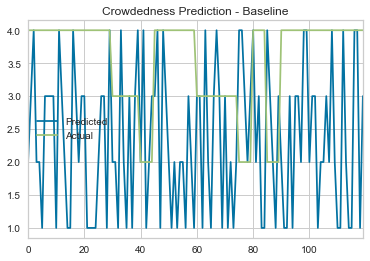

In [132]:
time_pred_series_bas_clas.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_bas_clas.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [133]:
y_pred_bas = clas_bas.predict(x_eval_clas)

print("Accuracy Score: ", accuracy_score(y_eval_clas, y_pred_bas))
print(classification_report(y_eval_clas, y_pred_bas))

Accuracy Score:  0.24731481481481482
              precision    recall  f1-score   support

           1       0.30      0.25      0.27      6655
           2       0.22      0.25      0.23      4684
           3       0.31      0.25      0.28      6776
           4       0.16      0.24      0.19      3485

   micro avg       0.25      0.25      0.25     21600
   macro avg       0.25      0.25      0.24     21600
weighted avg       0.26      0.25      0.25     21600



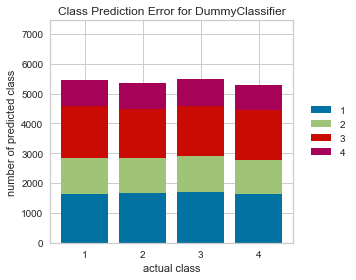

In [134]:
visualizer = ClassPredictionError(
    clas_bas
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_eval_clas, y_eval_clas)
g = visualizer.poof()

In [135]:
#Time series
time_pred_bas = clas_bas.predict(x_series_clas)

time_pred_series_bas = pd.Series(time_pred_bas)
time_real_series_bas = pd.Series(y_series_clas)

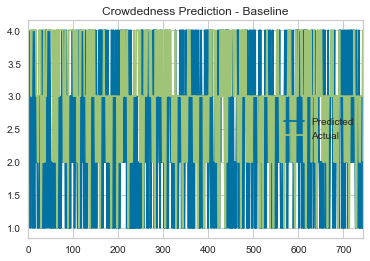

In [136]:
time_pred_series_bas.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_bas.plot(legend=True, label="Actual")
plt.show()

### Random Forrest Classifier <a name="classRFCModel"></a>
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier)

#### Train

In [137]:
clas_rfc = RandomForestClassifier(n_estimators=300, criterion="entropy", n_jobs=50, random_state=42, 
                                  class_weight="balanced", oob_score="True")

In [138]:
clas_rfc.fit(x_train_clas, y_train_clas)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=50, oob_score='True', random_state=42,
            verbose=0, warm_start=False)

#### Test

In [139]:
y_pred_clas_rfc = clas_rfc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_rfc))
print(classification_report(y_test_clas, y_pred_clas_rfc))

Accuracy Score:  1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     20795
           2       1.00      1.00      1.00     20795
           3       1.00      1.00      1.00     20845
           4       1.00      1.00      1.00     20826

   micro avg       1.00      1.00      1.00     83261
   macro avg       1.00      1.00      1.00     83261
weighted avg       1.00      1.00      1.00     83261



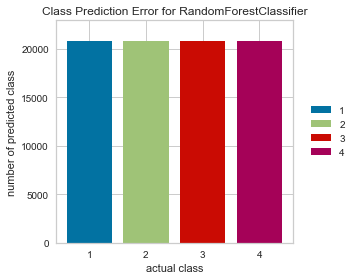

In [140]:
visualizer = ClassPredictionError(
    clas_rfc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [141]:
#Time series
time_pred_rfc_clas = clas_rfc.predict(x_test_clas_series)

time_pred_series_rfc_clas = pd.Series(time_pred_rfc_clas)
time_real_series_rfc_clas = pd.Series(y_test_clas_series)

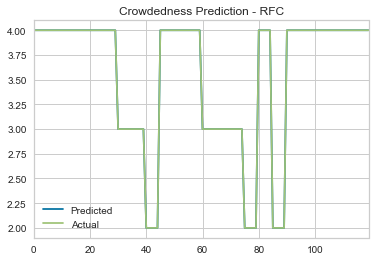

In [142]:
time_pred_series_rfc_clas.plot(legend=True, title='Crowdedness Prediction - RFC', label="Predicted")
time_real_series_rfc_clas.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [143]:
y_pred_rfc = clas_rfc.predict(x_eval_clas)

print("Accuracy Score: ", accuracy_score(y_eval_clas, y_pred_rfc))
print(classification_report(y_eval_clas, y_pred_rfc))

Accuracy Score:  0.7179166666666666
              precision    recall  f1-score   support

           1       0.85      0.71      0.77      6655
           2       0.58      0.70      0.63      4684
           3       0.81      0.66      0.73      6776
           4       0.63      0.87      0.73      3485

   micro avg       0.72      0.72      0.72     21600
   macro avg       0.72      0.73      0.72     21600
weighted avg       0.74      0.72      0.72     21600



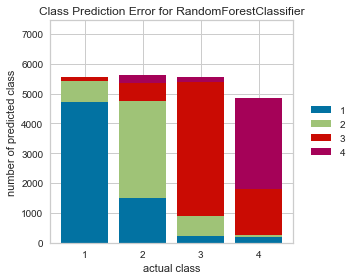

In [144]:
visualizer = ClassPredictionError(
    clas_rfc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_eval_clas, y_eval_clas)
g = visualizer.poof()

In [145]:
#Time series
time_pred_rfc = clas_rfc.predict(x_series_clas)

time_pred_series_rfc = pd.Series(time_pred_rfc)
time_real_series_rfc = pd.Series(y_series_clas)

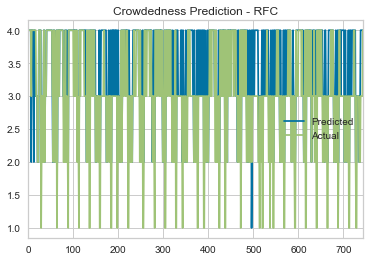

In [152]:
time_pred_series_rfc.plot(legend=True, title='Crowdedness Prediction - RFC', label="Predicted")
time_real_series_rfc.plot(legend=True, label="Actual")
plt.show()

### XGBoost 
Implement [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_intro.html)

#### Training

In [153]:
xgb_clas = xgb.XGBClassifier(random_state=42, n_estimators=300, max_depth=12, 
                              learning_rate=0.1, booster="gbtree", n_jobs=50)

In [154]:
xgb_clas.fit(x_train_clas, y_train_clas)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=12, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=50, nthread=None, objective='multi:softprob',
       random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

#### Test

In [155]:
y_pred_clas_xgb = xgb_clas.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_xgb))
print(classification_report(y_test_clas, y_pred_clas_xgb))

Accuracy Score:  0.999987989574951
              precision    recall  f1-score   support

           1       1.00      1.00      1.00     20795
           2       1.00      1.00      1.00     20795
           3       1.00      1.00      1.00     20845
           4       1.00      1.00      1.00     20826

   micro avg       1.00      1.00      1.00     83261
   macro avg       1.00      1.00      1.00     83261
weighted avg       1.00      1.00      1.00     83261



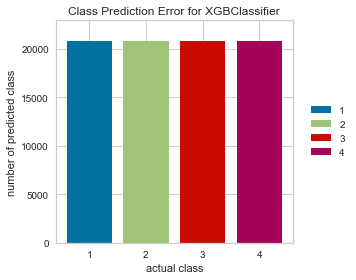

In [156]:
visualizer = ClassPredictionError(
    xgb_clas, 
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [157]:
#Time series
time_pred_clas_xgb = xgb_clas.predict(x_test_clas_series)

time_pred_series_clas_xgb = pd.Series(time_pred_clas_xgb)
time_real_series_clas_xgb = pd.Series(y_test_clas_series)

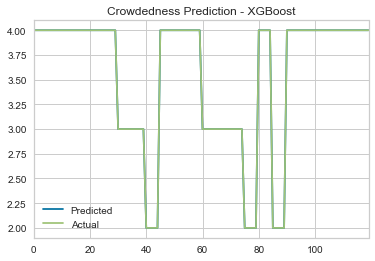

In [158]:
time_pred_series_clas_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_clas_xgb.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [159]:
y_pred_xgb = xgb_clas.predict(x_series_clas)

print("Accuracy Score: ", accuracy_score(y_series_clas, y_pred_xgb))
print(classification_report(y_series_clas, y_pred_xgb))

Accuracy Score:  0.5645161290322581
              precision    recall  f1-score   support

           1       0.62      0.10      0.17        51
           2       0.60      0.59      0.60       122
           3       0.72      0.40      0.52       365
           4       0.48      0.95      0.64       206

   micro avg       0.56      0.56      0.56       744
   macro avg       0.60      0.51      0.48       744
weighted avg       0.63      0.56      0.54       744



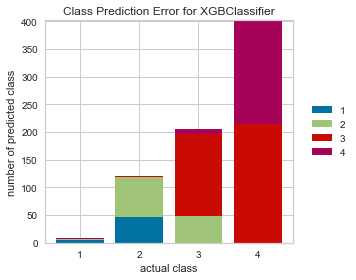

In [160]:
visualizer = ClassPredictionError(
    xgb_clas, 
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_series_clas, y_series_clas)
g = visualizer.poof()

In [161]:
#Time series
time_pred_xgb = xgb_clas.predict(x_series_clas)

time_pred_series_xgb = pd.Series(time_pred_xgb)
time_real_series_xgb = pd.Series(y_series_clas)

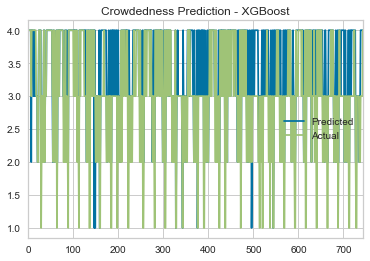

In [162]:
time_pred_series_xgb.plot(legend=True, title='Crowdedness Prediction - XGBoost', label="Predicted")
time_real_series_xgb.plot(legend=True, label="Actual")
plt.show()

### SVC 
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)

#### Training

In [163]:
clas_svc = SVC(kernel="rbf", random_state=42, class_weight="balanced", C=0.5, decision_function_shape="ovo", gamma="auto")

In [164]:
clas_svc.fit(x_train_clas, y_train_clas)

D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=0.5, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

#### Test

In [165]:
y_pred_clas_svc = clas_svc.predict(x_test_clas)

print("Accuracy Score: ", accuracy_score(y_test_clas, y_pred_clas_svc))
print(classification_report(y_test_clas, y_pred_clas_svc))

Accuracy Score:  0.6829848308331632
              precision    recall  f1-score   support

           1       0.86      0.55      0.67     20795
           2       0.73      0.58      0.65     20795
           3       0.68      0.69      0.69     20845
           4       0.59      0.91      0.71     20826

   micro avg       0.68      0.68      0.68     83261
   macro avg       0.71      0.68      0.68     83261
weighted avg       0.71      0.68      0.68     83261



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


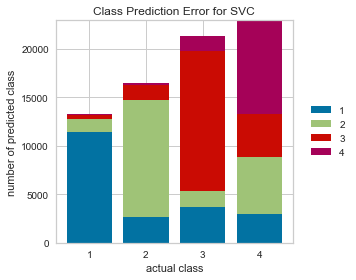

In [166]:
visualizer = ClassPredictionError(
    clas_svc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_test_clas, y_test_clas)
g = visualizer.poof()

In [167]:
#Time series
time_pred_clas_svc = clas_svc.predict(x_test_clas_series)

time_pred_series_clas_svc = pd.Series(time_pred_clas_svc)
time_real_series_clas_svc = pd.Series(y_test_clas_series)

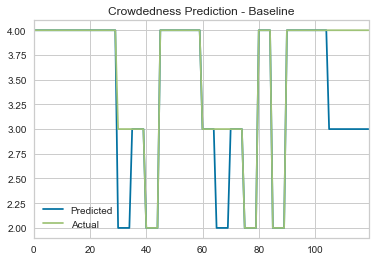

In [168]:
time_pred_series_clas_svc.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_clas_svc.plot(legend=True, label="Actual")
plt.show()

#### Evaluation

In [169]:
y_pred_svc = clas_svc.predict(x_series_clas)

print("Accuracy Score: ", accuracy_score(y_series_clas, y_pred_svc))
print(classification_report(y_series_clas, y_pred_svc))

Accuracy Score:  0.4368279569892473
              precision    recall  f1-score   support

           1       1.00      0.06      0.11        51
           2       0.87      0.33      0.48       122
           3       0.86      0.21      0.34       365
           4       0.34      1.00      0.51       206

   micro avg       0.44      0.44      0.44       744
   macro avg       0.77      0.40      0.36       744
weighted avg       0.72      0.44      0.39       744



D:\Programs\Anaconda\envs\Analytics\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


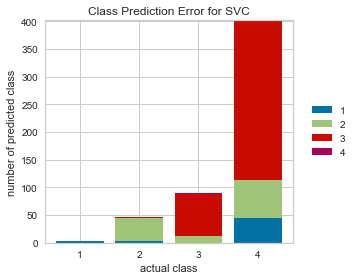

In [170]:
visualizer = ClassPredictionError(
    clas_svc
)

visualizer.fit(x_train_clas, y_train_clas)
visualizer.score(x_series_clas, y_series_clas)
g = visualizer.poof()

In [171]:
#Time series
time_pred_svc = clas_svc.predict(x_series_clas)

time_pred_series_svc = pd.Series(time_pred_svc)
time_real_series_svc = pd.Series(y_series_clas)

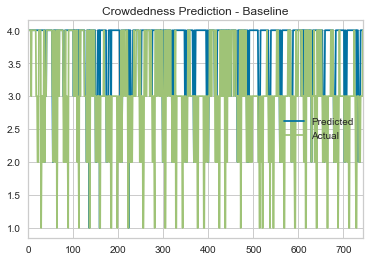

In [172]:
time_pred_series_svc.plot(legend=True, title='Crowdedness Prediction - Baseline', label="Predicted")
time_real_series_svc.plot(legend=True, label="Actual")
plt.show()

### Logistic Regression
Implemented the [Sklearn Version](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

#### Training

#### Test

#### Evaluation